# Comparing electron temperatures from EFI IDM and EFI LP products

This notebook accesses the EFIxIDM and EFIxLP [products](https://earth.esa.int/eogateway/documents/20142/0/Swarm-LP-Ion-Drift-and-Effective-Mass-Product-Definition-SLIDEM) from the Swarm TII cross-track flow data and plot the electron temperature of two different collections against each other for a same time period.

### Avaiable for Users Variables to change

| VirES Variable | Description | 
|---|---|
|`SPACECRAFT`| Spacecraft options which user can change manually. Available 3 options "A", "B", "C" |
|`START_TIME/END_TIME`| Time for which to request data. This should be in ISO format (e.g. "2016-01-02T00:00:00Z") |

In [1]:
SPACECRAFT = "B" 
START_TIME = '2022-06-30T00:00:00Z'
END_TIME = '2022-07-30T00:00:00Z'

In [2]:
from viresclient import SwarmRequest

SERVER_URL = "https://vires.services/ows"
request = SwarmRequest(SERVER_URL)
collection_efi_idm = f'SW_PREL_EFI{SPACECRAFT}IDM_2_'
collection_efi_lp =f'SW_OPER_EFI{SPACECRAFT}_LP_1B'

start_orbit_number = request.get_orbit_number(SPACECRAFT, START_TIME)
end_orbit_number = request.get_orbit_number(SPACECRAFT, END_TIME)
start_time, end_time =  request.get_times_for_orbits(start_orbit_number, end_orbit_number, mission = 'Swarm', spacecraft=SPACECRAFT)

In [3]:
def request_data(url, collection, measurements,start_time, end_time):
    """
    Make a request for data from the Swarm API.
    """
    request = SwarmRequest(url)
    request.set_collection(collection)
    request.set_products(
        measurements=measurements,
        auxiliaries=['OrbitDirection', 'OrbitNumber', 'QDLat', 'QDOrbitDirection'],
    )

    data = request.get_between(
        start_time=start_time,
        end_time=end_time,
        asynchronous=True,
    ).as_xarray()
    return data

In [4]:
data_idm = request_data(SERVER_URL, collection_efi_idm, ['T_e'],start_time, end_time)
data_lp = request_data(SERVER_URL, collection_efi_lp, ['Te'],start_time, end_time)

          |  [ Elapsed: 00:00, Remaining: ?]  

Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/2] 

Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (235.741MB)

Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [2/2] 

Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (47.866MB)

          |  [ Elapsed: 00:00, Remaining: ?]  

Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/2] 

Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (237.584MB)

Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [2/2] 

Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (48.238MB)

### Plotting over time and latitude

The plots show how the electron temperature varies over time and QD latitude for the two different data collections. By comparing the two plots, we can see if there are any notable differences in the electron temperature between the two collections.

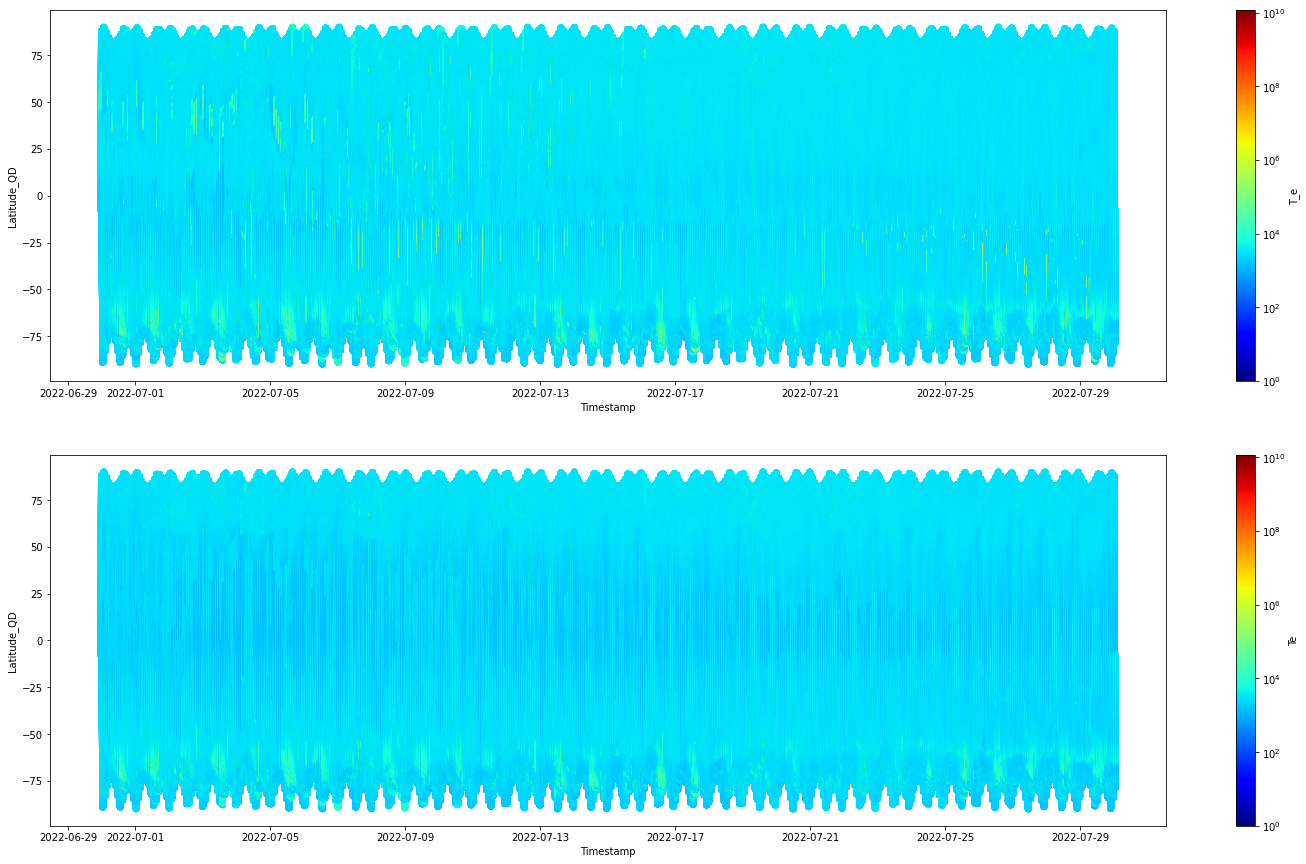

In [8]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np


def sc_plot(ax,data, measurements,vmin, vmax):
    mask = (data[measurements].values>=0) & (~np.isnan(data[measurements].values))

    timestamps = data["Timestamp"].values[mask]
    latitudes = data["QDLat"].values[mask]
    efi_te = data[measurements].values[mask]
    efi_te = efi_te[~np.isnan(efi_te)]

    norm=LogNorm(vmin=vmin, vmax=vmax)
    sc = ax.scatter(timestamps, latitudes, c=efi_te, cmap='jet', norm=norm)
    ax.set_xlabel('Timestamp')
    ax.set_ylabel('Latitude_QD')
    cbar = fig.colorbar(sc, ax=ax)
    cbar.set_label(measurements)  

te_max = max(data_idm['T_e'].values.max(), data_lp['Te'].values.max())
    
fig, ax = plt.subplots(figsize=(25, 15), nrows =2, ncols=1)
sc_plot(ax[0],data_idm, "T_e",1,te_max )
sc_plot(ax[1], data_lp, "Te",1, te_max)


### Time conversion functions and other utilities 

Some special functions do not like to time data types and require the time to be converted to a number.

In [9]:
import numpy as np

EPOCH = np.datetime64("2000-01-01")


def times_to_seconds(times, epoch=None, precision="ns", scale=1e-9):
    """ Convert times (datetime64) to seconds (float).
    
    The epoch (zero value) is set by default to 2000-01-01T00:00:00.
    """
    if epoch is None:
        epoch = EPOCH
    return dtimes_to_seconds(np.asarray(times, "datetime64[ns]") - epoch, precision, scale)


def seconds_to_times(seconds, epoch=None, precision="ns", scale=1e9):
    """ Convert seconds (float) to times (datetime64).
    
    The epoch (zero value) is set by default to 2000-01-01T00:00:00.
    """
    if epoch is None:
        epoch = EPOCH
    return seconds_to_dtimes(seconds, precision, scale) + epoch


def dtimes_to_seconds(dtimes, precision="ns", scale=1e-9):
    """ Convert time differences (timedelta64) to seconds (float)
    with nanosecond precision.
    """
    return scale * np.asarray(dtimes, f"timedelta64[{precision}]").astype("int64")


def seconds_to_dtimes(seconds, precision="ns", scale=1e9):
    """ Convert seconds to time differences (timedelta64)
    with nanosecond precision.
    """
    return (scale * np.asarray(seconds)).astype("int64").astype(f"timedelta64[{precision}]")


### Matching corresponding times from two datasets

The `match_times()` function below finds corresponding times from two time-series which are not guaraneed to be sampled equally.


In [10]:
from viresclient._wps.time_util import parse_duration
from scipy.interpolate import interp1d
import numpy as np


def match_times(times1, times2, atol):
    assert times1.ndim == 1 # assert 1D array
    assert times2.ndim == 1 # assert 1D array
    
    epoch = times1[0] if times1.size > 0 else None
    seconds1 = times_to_seconds(times1, epoch=epoch)
    seconds2 = times_to_seconds(times2, epoch=epoch)
    seconds_atol = dtimes_to_seconds(atol)
    
    # find the nearest neigbour
    assert ((seconds2[1:] - seconds2[:-1]) >= 0).all() # assert sorted values
    idx2 = interp1d(
        seconds2, np.arange(seconds2.size),
        kind='nearest',
        copy=False,
        fill_value="extrapolate",
        assume_sorted=True,
    )(seconds1).astype("int64")

    # pick values within the given tolerance
    idx1 = (abs(seconds2[idx2] - seconds1) <= seconds_atol).nonzero()[0]
    idx2 = idx2[idx1]
    
    return idx1, idx2

idx_lp, idx_idm = match_times(
    data_lp["Timestamp"].values,
    data_idm["Timestamp"].values,
    atol=parse_duration("PT0.5S"),
)

### Scatter plot

Here, we are creating scatter plots that visualize the correlation between electron temperature measurements from two different data collections, EFI LP and EFI IDM. The red line on each plot represents the line of perfect correlation, where the electron temperature values from both collections are exactly the same. The scatter points represent the individual measurements and their position on the plot indicates their relative electron temperature values between the two data collections. A tight clustering of points around the red line indicates a strong correlation between the two data sets, while a scattered distribution of points indicates a weak correlation. 
The scatter plot is useful for identifying individual outliers or patterns in the data.

In [11]:
te_lp = data_lp["Te"].values[idx_lp]
te_idm = data_idm["T_e"].values[idx_idm]

def _get_lim(values1, values2):
    return (
        min(values1.min(), values2.min()),
        max(values1.max(), values2.max()),
    )

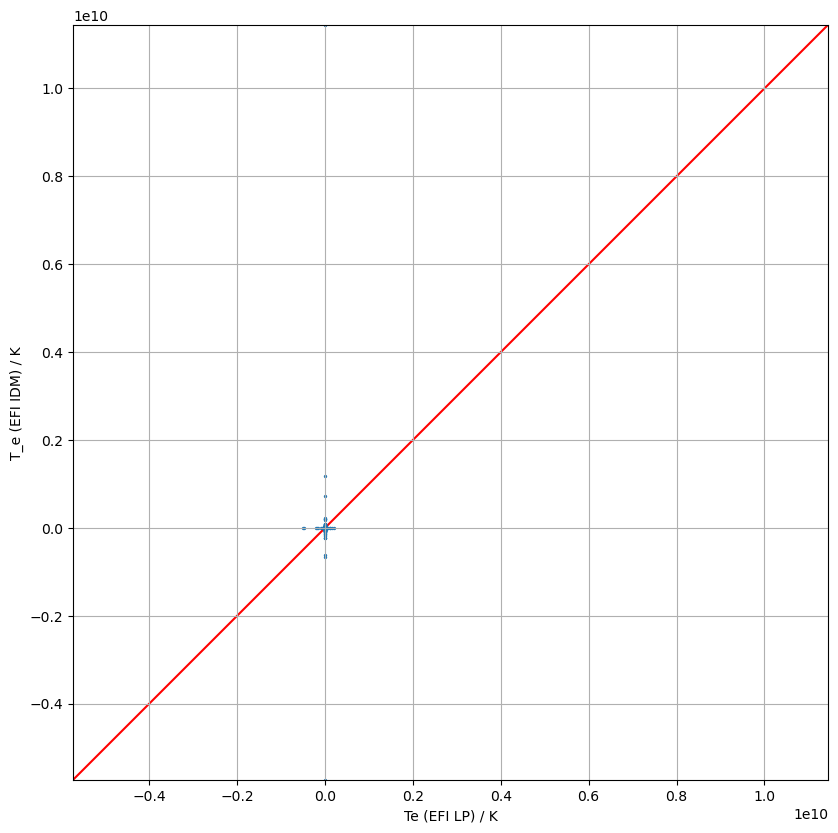

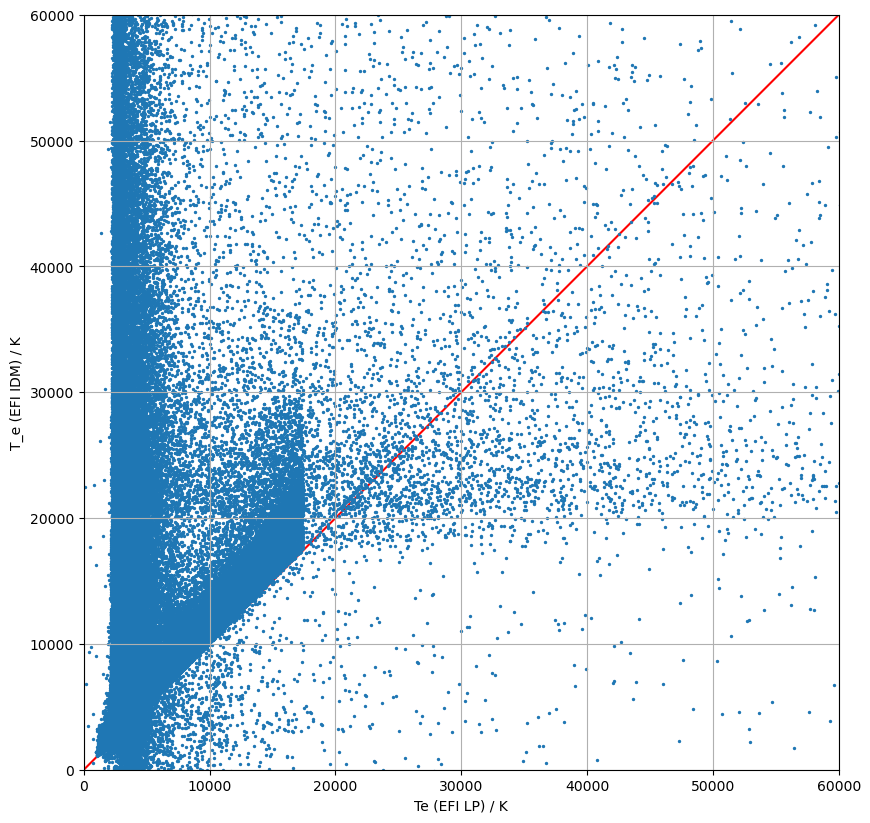

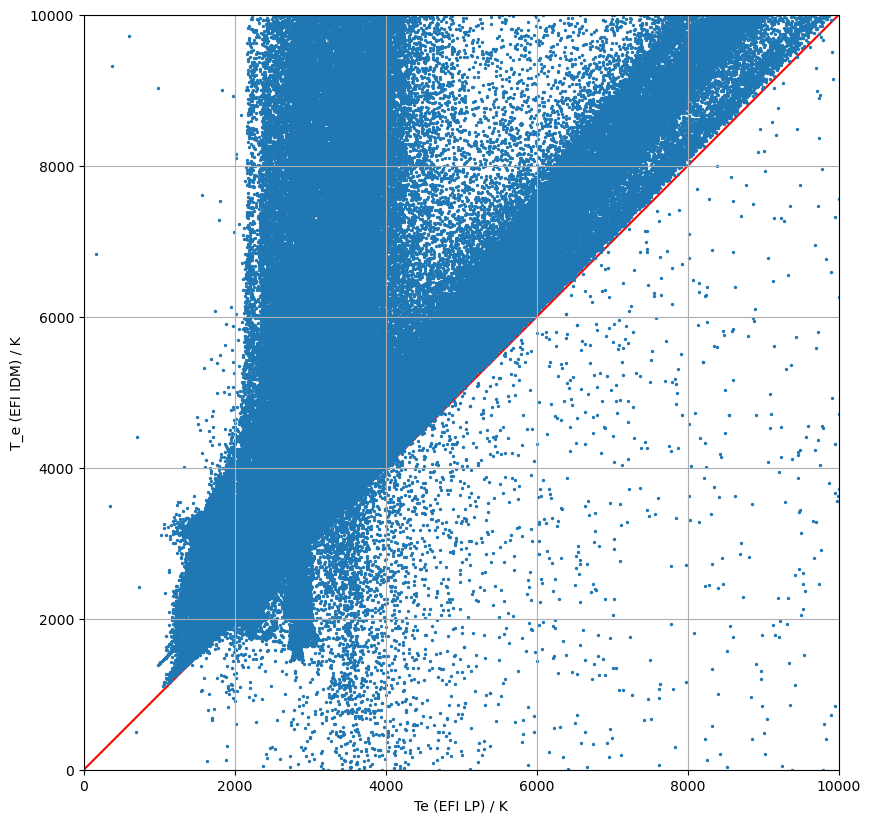

In [12]:
from matplotlib.pyplot import figure

def plot_scatter(ax, lim):
    ax.plot(lim, lim, "-", color="red", zorder=0)
    ax.scatter(te_lp, te_idm, s=2)
    ax.grid()
    ax.set_xlabel("Te (EFI LP) / K")
    ax.set_ylabel("T_e (EFI IDM) / K")
    ax.set_xlim(lim)
    ax.set_ylim(lim)
    ax.set_aspect("equal")

    
fig = figure(figsize=(15, 10), dpi=100)
ax = fig.subplots()
plot_scatter(ax, lim=_get_lim(te_lp, te_idm))

fig = figure(figsize=(15, 10), dpi=100)
ax = fig.subplots()
plot_scatter(ax, lim=[0, 6e4])

fig = figure(figsize=(15, 10), dpi=100)
ax = fig.subplots()
plot_scatter(ax, lim=[0, 1e4])

Three scatter plots differ in their zoom levels, which affects the range of values visible on the x and y axes.

### 2D histogram plot

Those plots visualize the distribution of data across two variables, which are the electron temperature values obtained from two different collections and identify any areas of high or low density in the data.The advantage of the 2D histogram is that it provides a better visual representation of the distribution of the data and provide more accurate representation of the data density, especially when the number of data points is large.

In [21]:
import numpy as np
from scipy.stats import binned_statistic_2d


def bin_data_2d(x, y, v, x_step, y_step, x_extent=None, y_extent=None, statistic='mean'):
    """ Conventience wrapper around the scipy.stats.binned_statistic_2d.
    See also https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.binned_statistic_2d.html

    Returns:
        result ... the calculated binned statictics (Ny x Nx array)
        x_edge ... edges of the bins in the x coordinate (Nx + 1 array)
        y_edge ... edges of the bins in the y coordinate (Ny + 1 array)

    Args:
        x ... 1st coordinate values
        y ... 2nd coordinate values
        v ... binned values
        x_step ... x proposed binning step (adjusted to fit the x_extent)
        y_step ... y proposed binning step (adjusted to fit the y_extent)
        x_extent ... optional pair of min. and max. boulds for the x coordinate
        y_extent ... optional pait of min. and max. boulds for the y coordinate
        staticstics ... type of the statistic to be calculated. For the possible
            options see the scipy.stats.binned_statistic_2d documentation.
    """

    def _get_bins(start, end, step):
        nstep = abs(int(np.ceil((end - start)/step))) + 1
        return np.linspace(start, end, nstep)

    if x_extent is None:
        x_extent = [x.min(), x.max()]

    if y_extent is None:
        y_extent = [y.min(), y.max()]

    result, x_edges, y_edges, _ = binned_statistic_2d(
        x, y, v, statistic=statistic, bins=(
            _get_bins(x_extent[0], x_extent[1], x_step),
            _get_bins(y_extent[0], y_extent[1], y_step),
        ),
    )
    return result.T, x_edges, y_edges

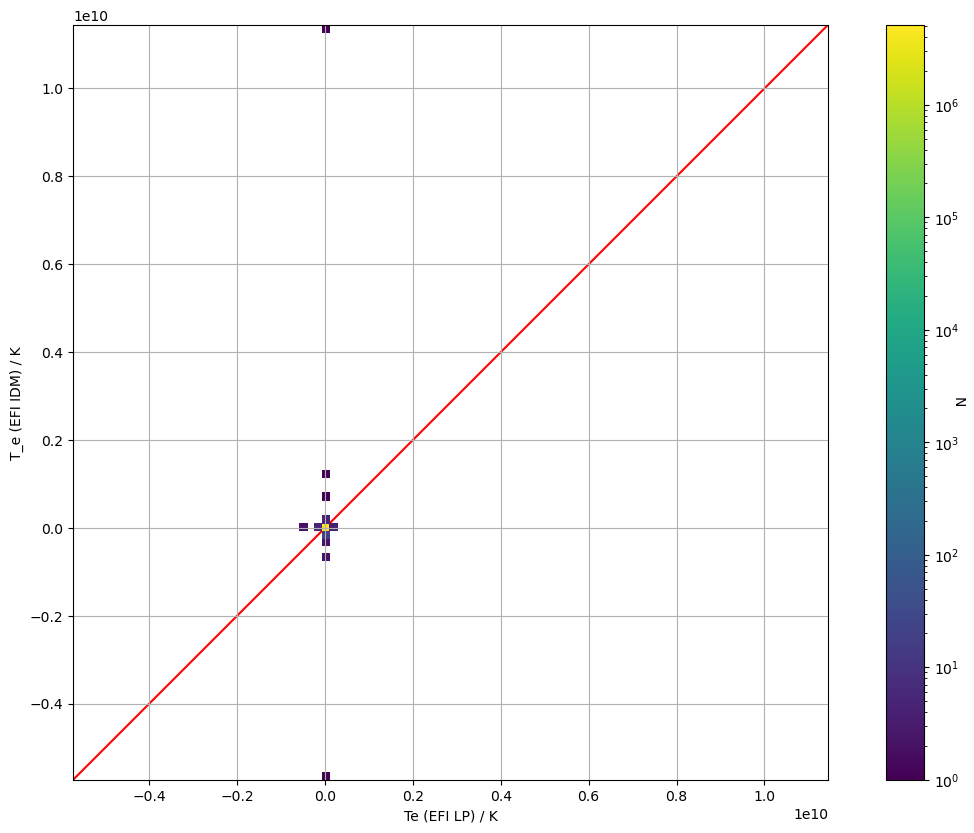

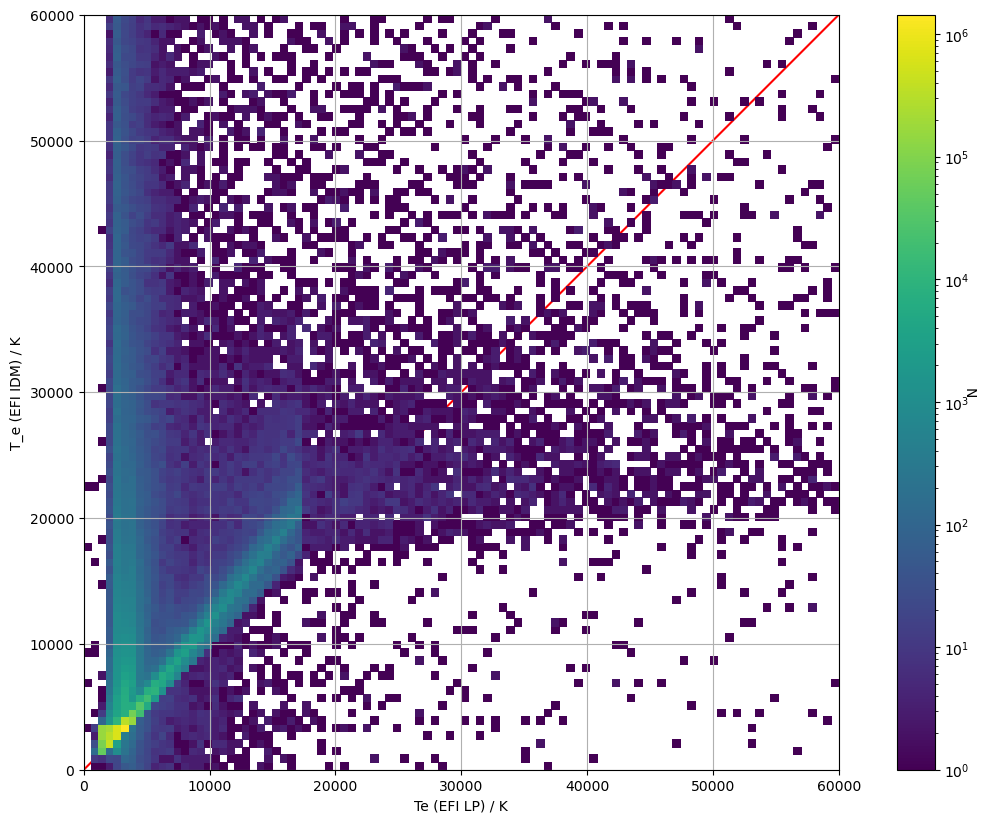

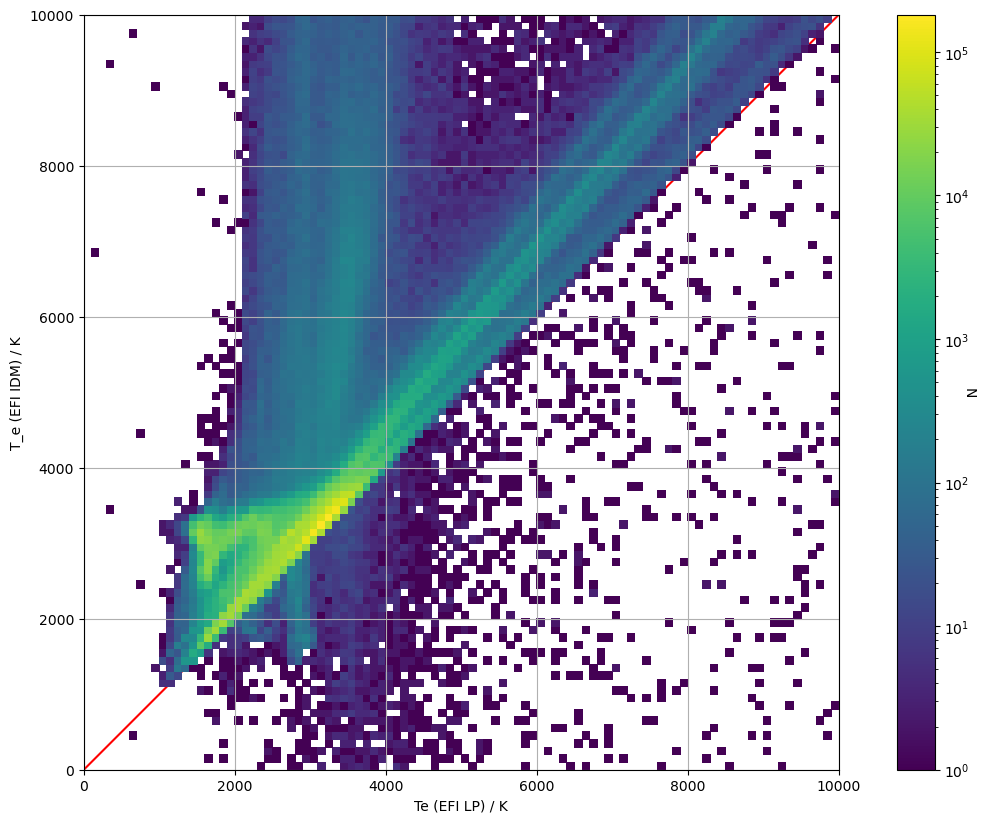

In [22]:
import matplotlib.pyplot as plt
import matplotlib as mpl

def plot_scatter(ax, lim, nbins=100):
    # 2D binning
    step = (lim[1] - lim[0]) / nbins
    v, x, y = bin_data_2d(
        x=te_lp,
        y=te_idm,
        v=np.ones(te_lp.shape),
        x_step=step,
        y_step=step,
        x_extent=lim,
        y_extent=lim, 
        statistic='count'
    )
    # plotting
    ax.plot(lim, lim, "-", color="red", zorder=0)
    norm = mpl.colors.LogNorm(vmin=1, vmax=v.max())
    im = ax.pcolor(x, y, v, norm=norm)
    cax = plt.colorbar(im, ax=ax)
    cax.ax.set_ylabel('N', rotation=270)
    
    ax.grid()
    ax.set_xlabel("Te (EFI LP) / K")
    ax.set_ylabel("T_e (EFI IDM) / K")
    ax.set_xlim(lim)
    ax.set_ylim(lim)
    ax.set_aspect("equal")

    
fig = plt.figure(figsize=(15, 10), dpi=100)
ax = fig.subplots()
plot_scatter(ax, lim=_get_lim(te_lp, te_idm))

fig = figure(figsize=(15, 10), dpi=100)
ax = fig.subplots()
plot_scatter(ax, lim=[0, 6e4])

fig = figure(figsize=(15, 10), dpi=100)
ax = fig.subplots()
plot_scatter(ax, lim=[0, 1e4])

Difference between three 2D binning and heatmap plot is the zoom level, which changes the visible range of values on the x and y axes.